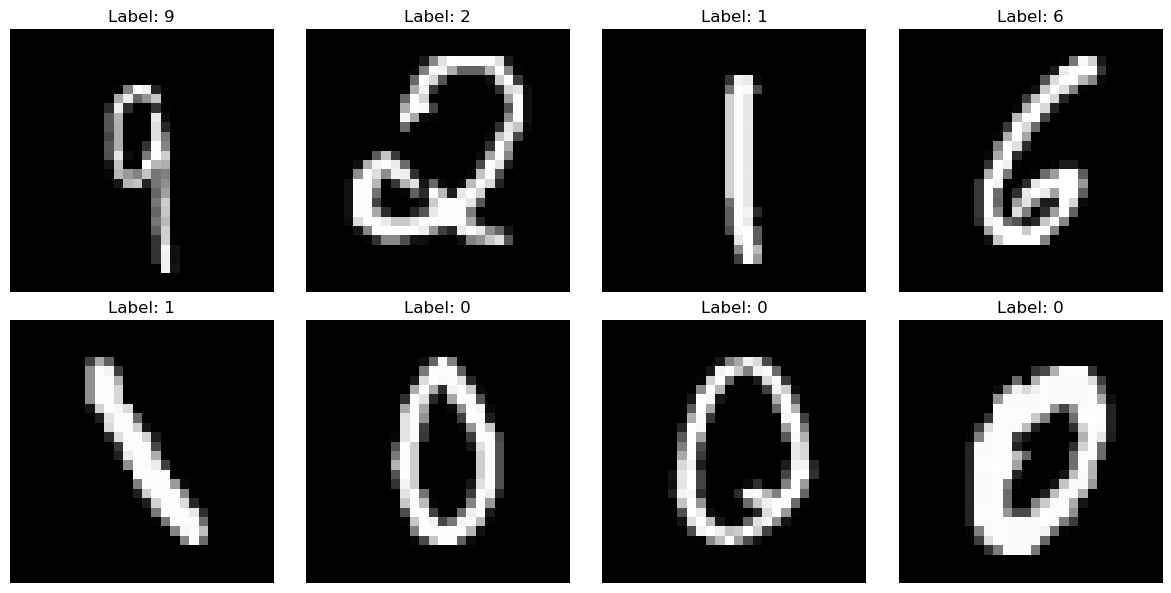

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):

        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = self.data['label'].values
        self.images = self.data.drop('label', axis=1).values.astype(np.float32)
        self.images = self.images / 255.0  # Normalize pixel values to [0, 1]
        self.images = self.images.reshape(-1, 1, 28, 28)  # Reshaping to 28 x 28 since MNIST images are 28 x 28 l times w
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return torch.tensor(image), torch.tensor(label)


def load_mnist_dataset(csv_path, batch_size=8, shuffle=True):
    dataset = MNISTDataset(csv_file=csv_path)
    dataloader = DataLoader(dataset, batch_size=batch_size , shuffle=shuffle) # batch_size = 8
    return dataloader

# 3. Visualize a Batch of 8 Images and Labels
def visualize_batch(dataloader):
    # Get one batch
    images, labels = next(iter(dataloader)) # next iter of dataloader gives a batch of 8 images (not 1) and labels using the __getitem__ method
    
    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        img = img.squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label.item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


csv_path = 'mnist_train.csv'  

# Load DataLoader
dataloader = load_mnist_dataset(csv_path, batch_size=8, shuffle=True)

# Visualize a batch
visualize_batch(dataloader)


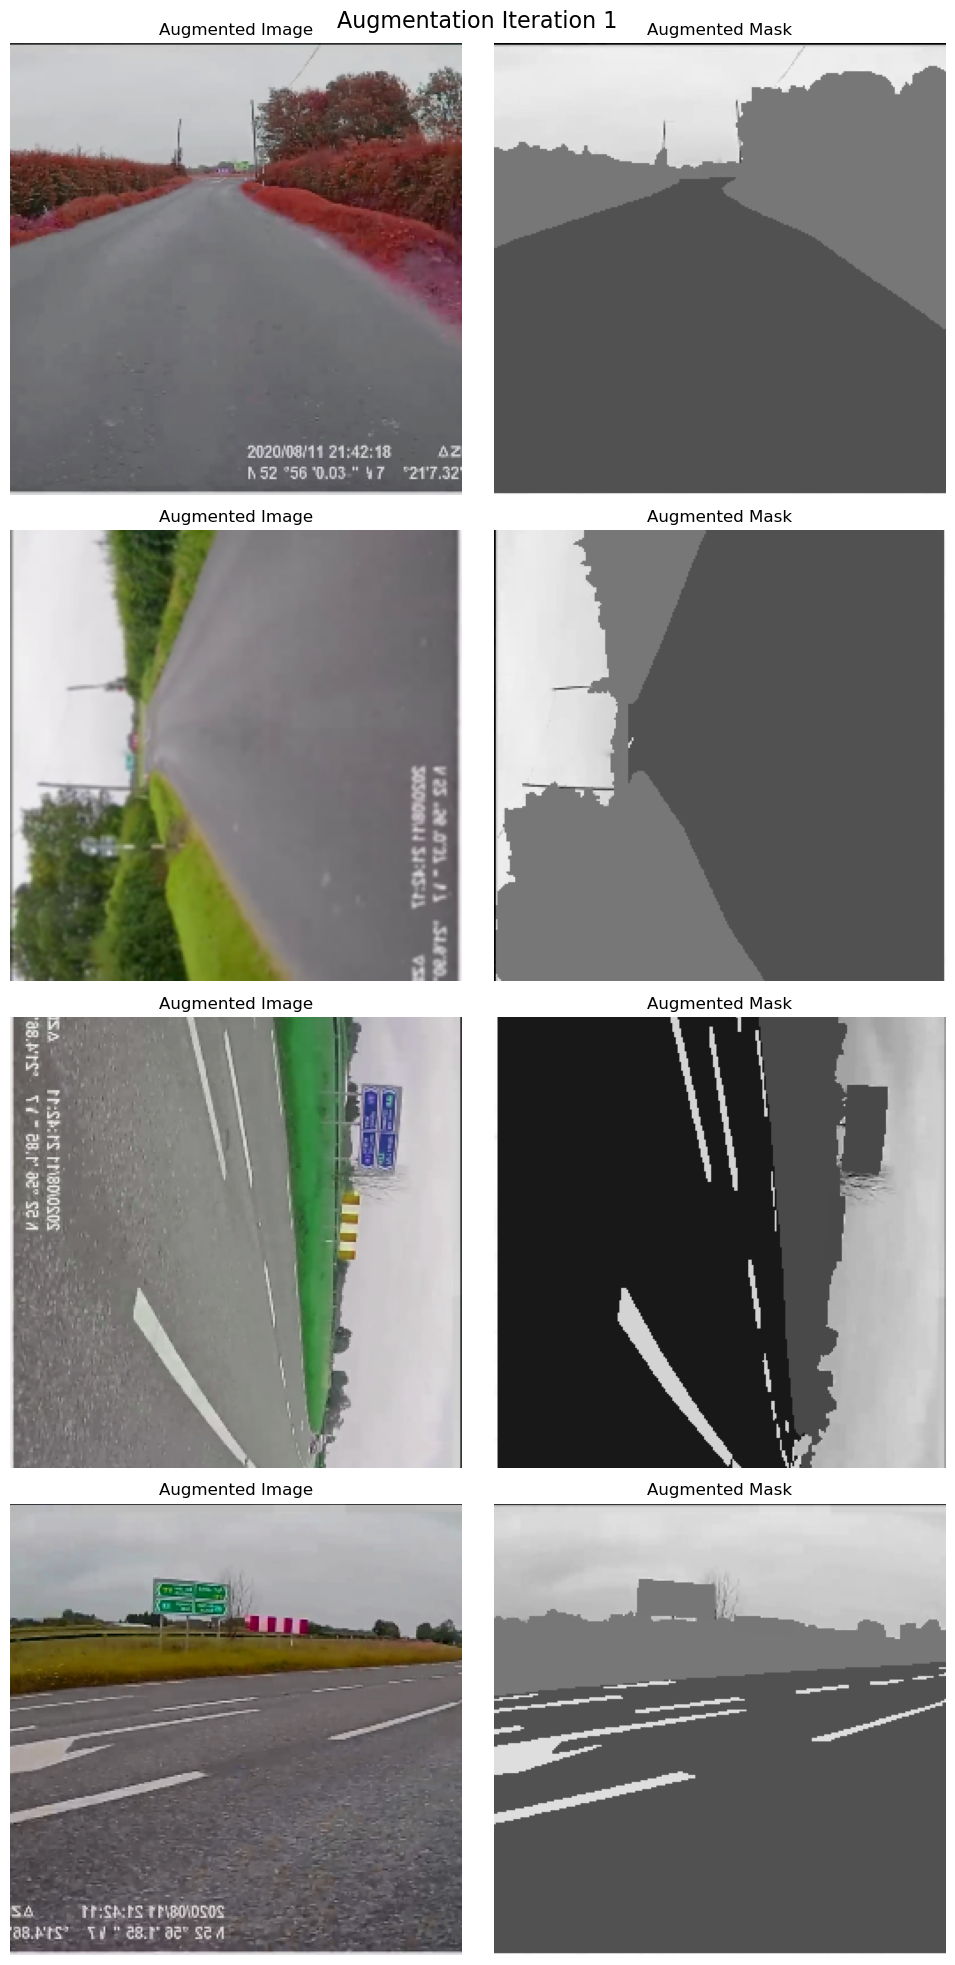

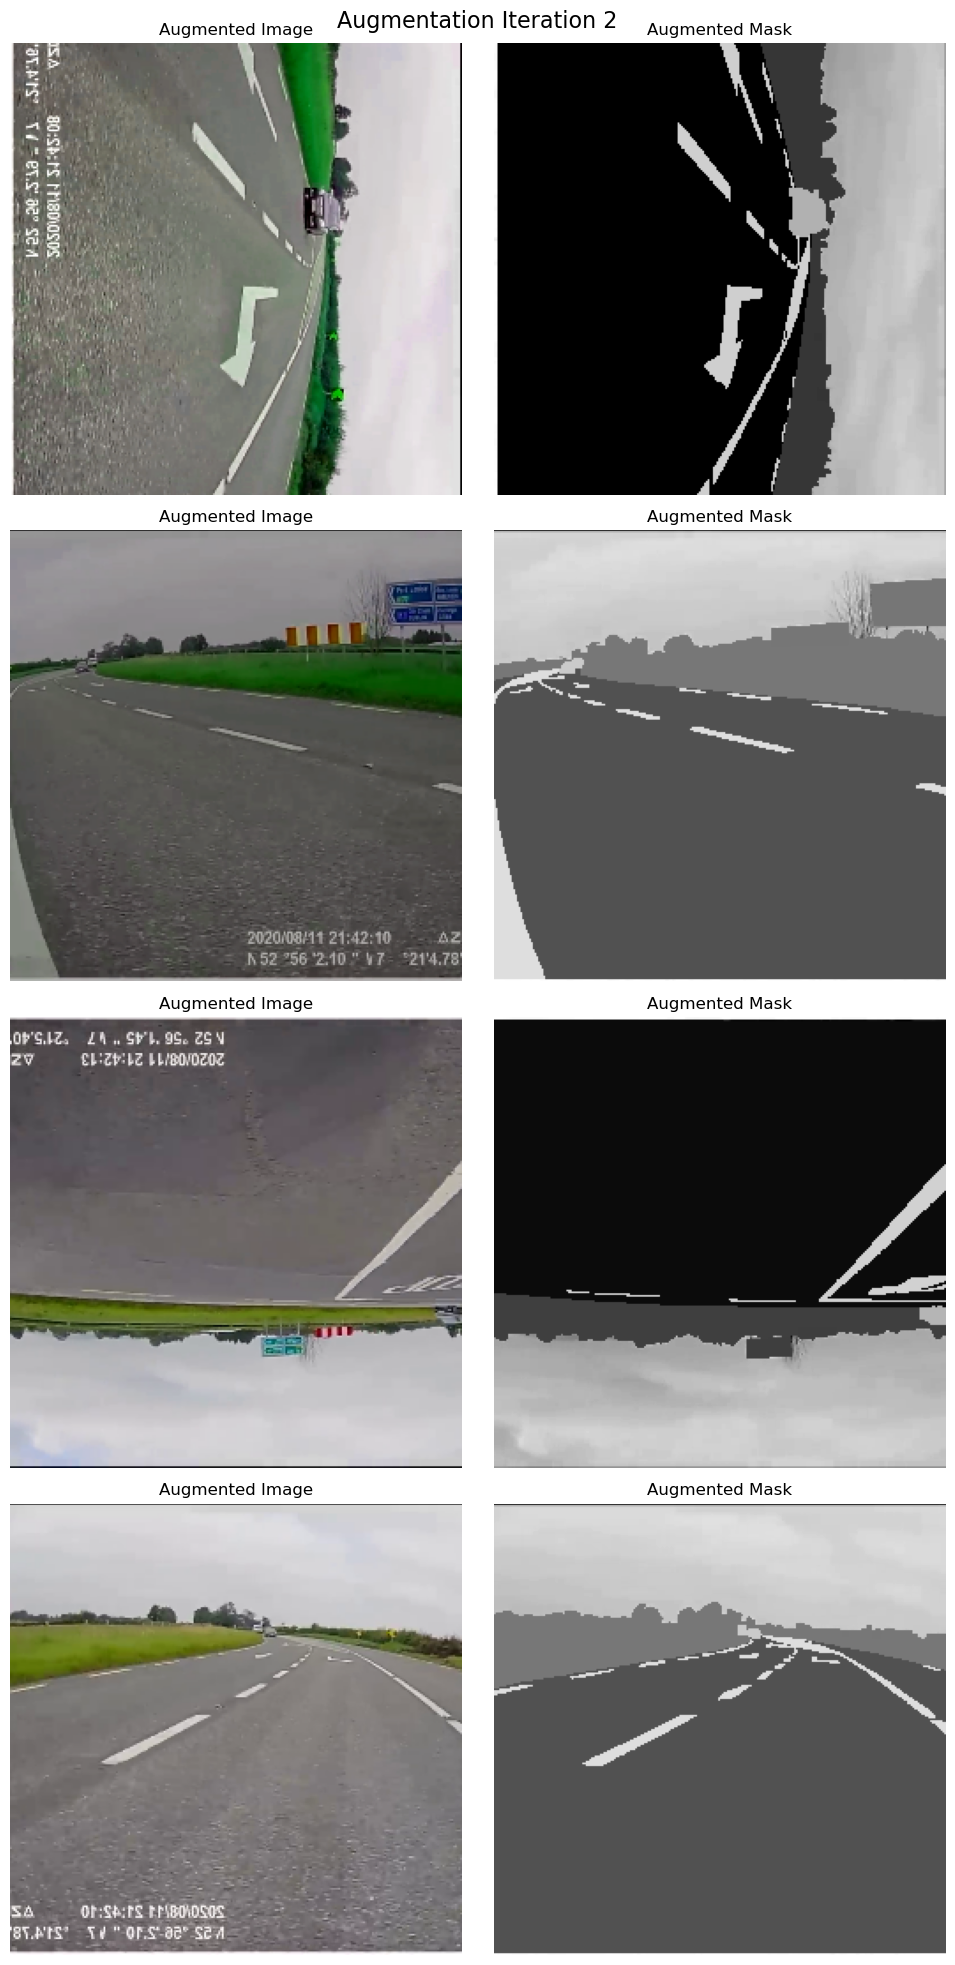

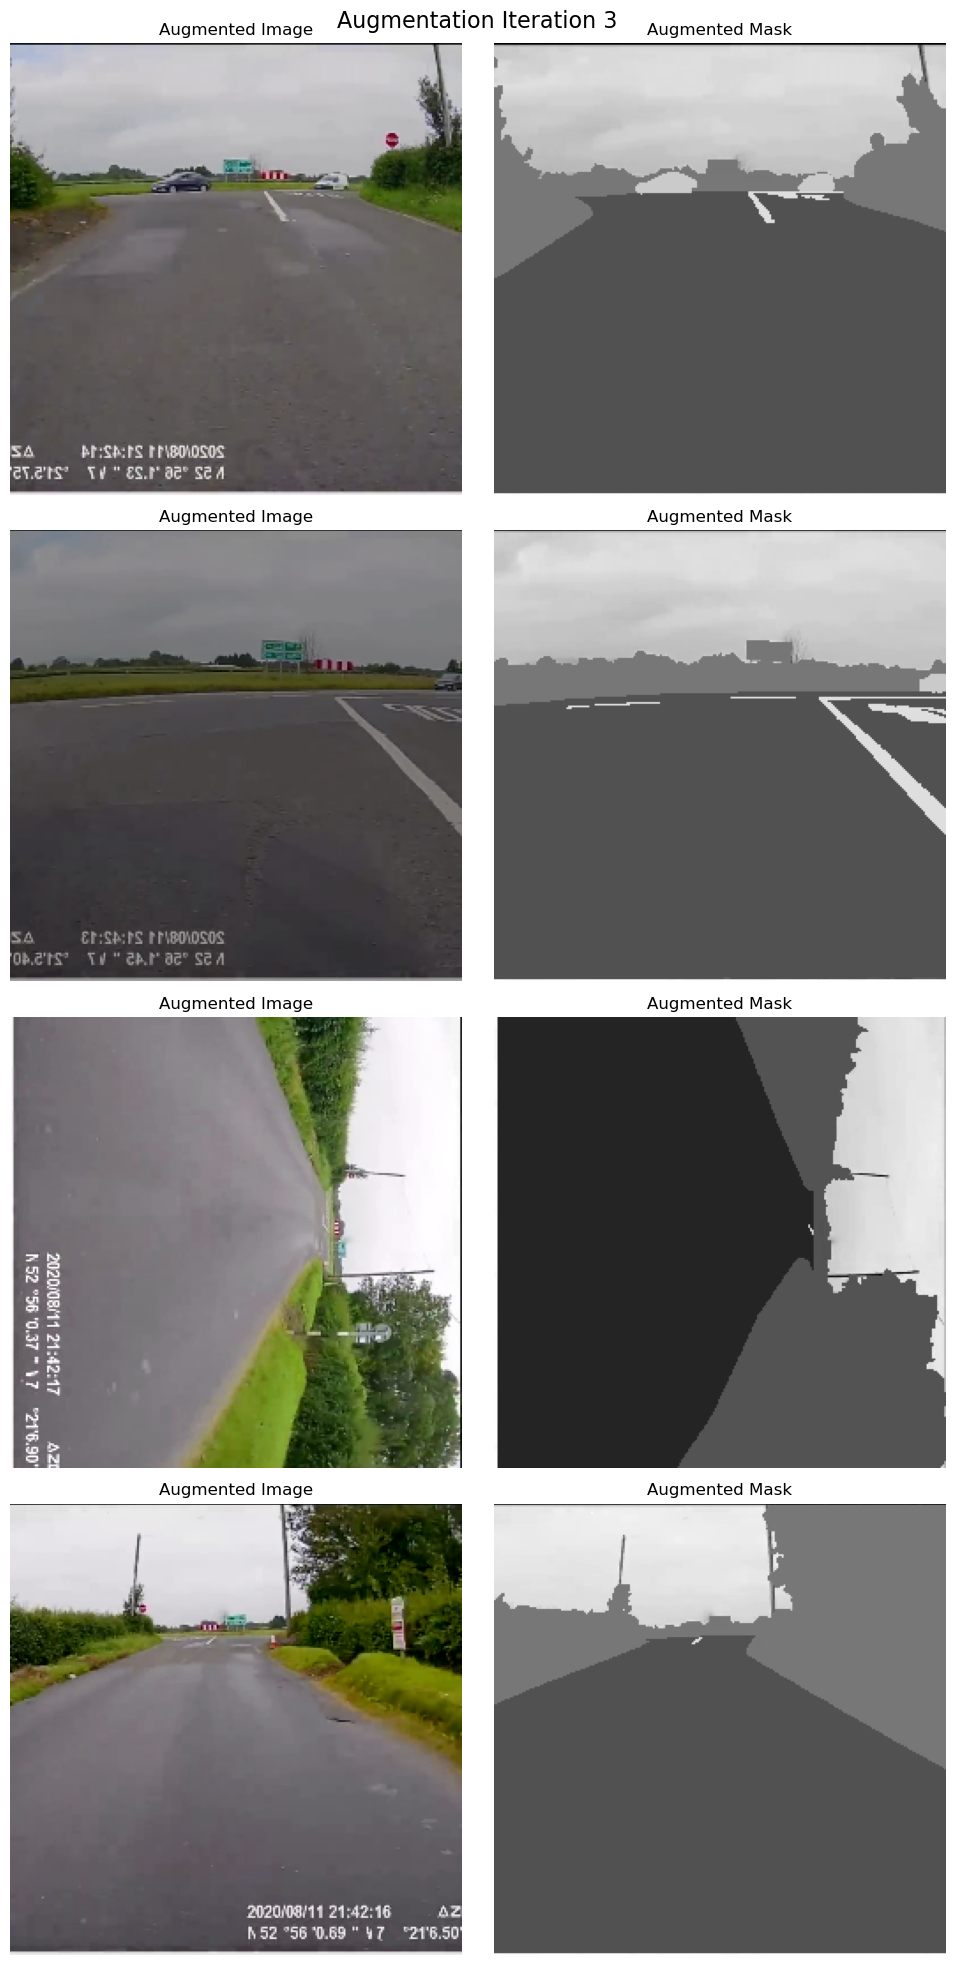

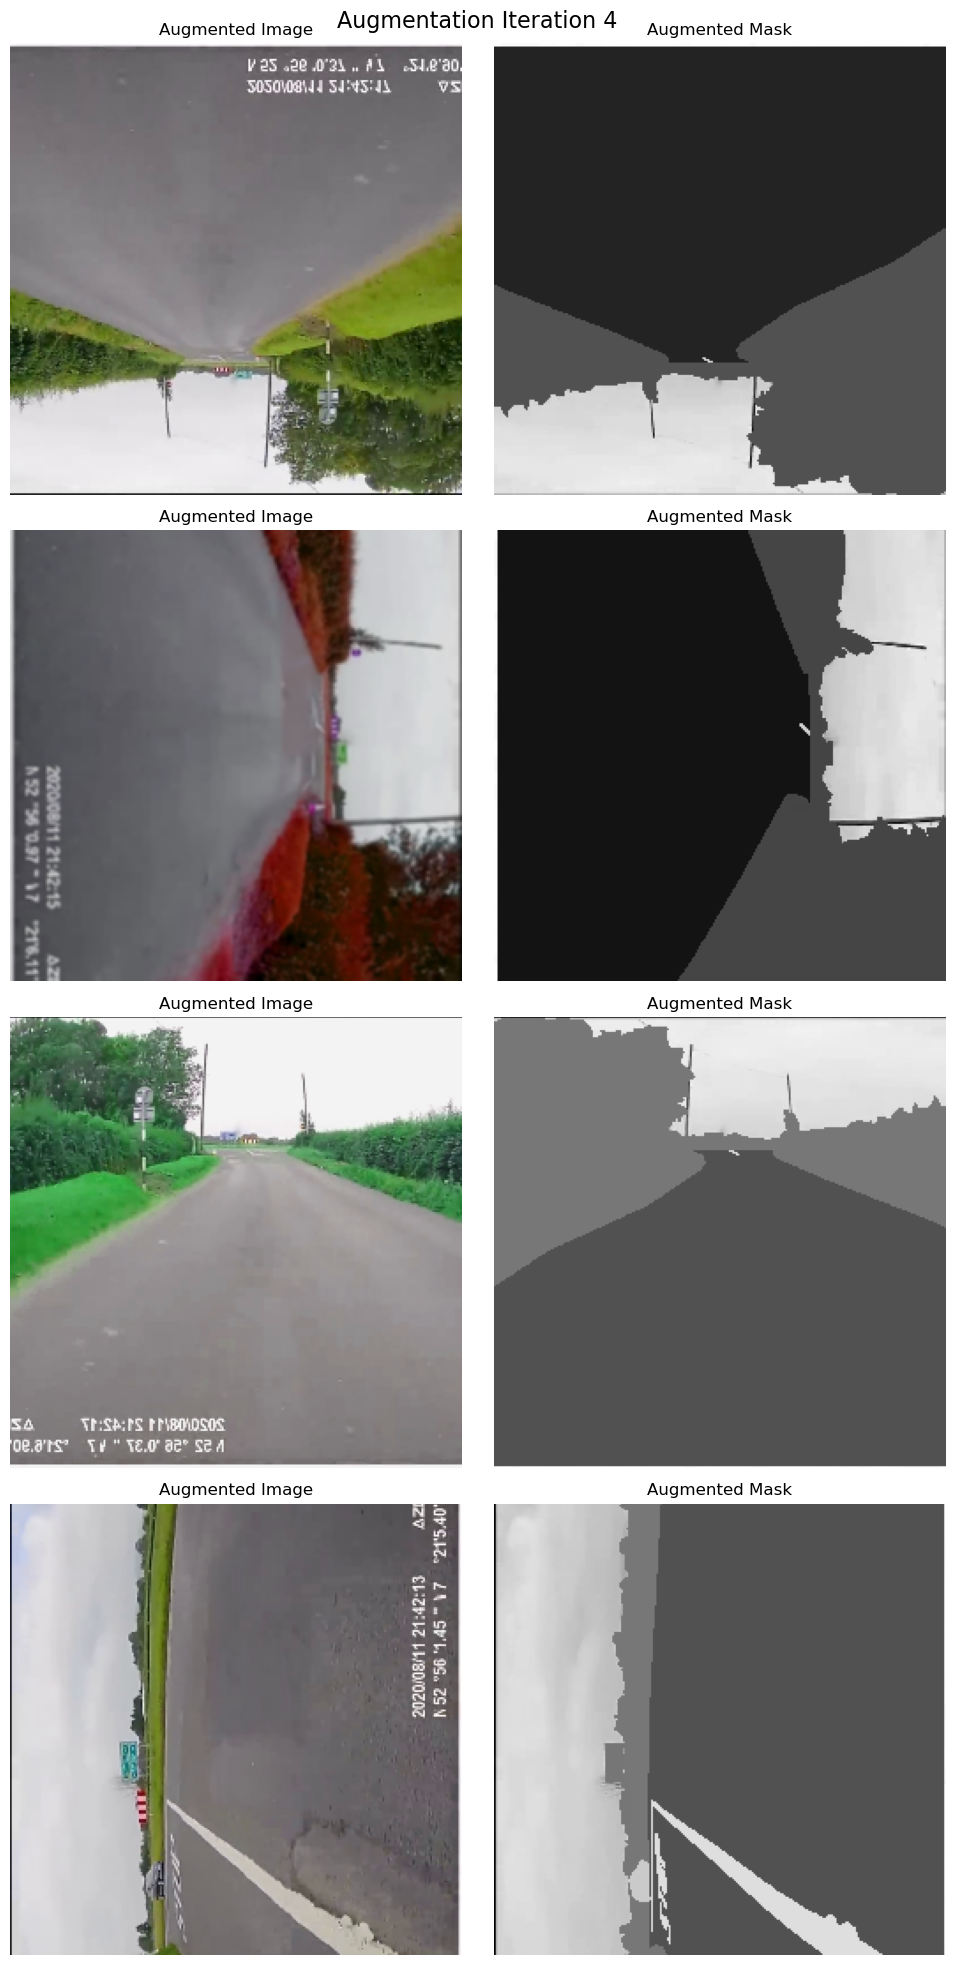

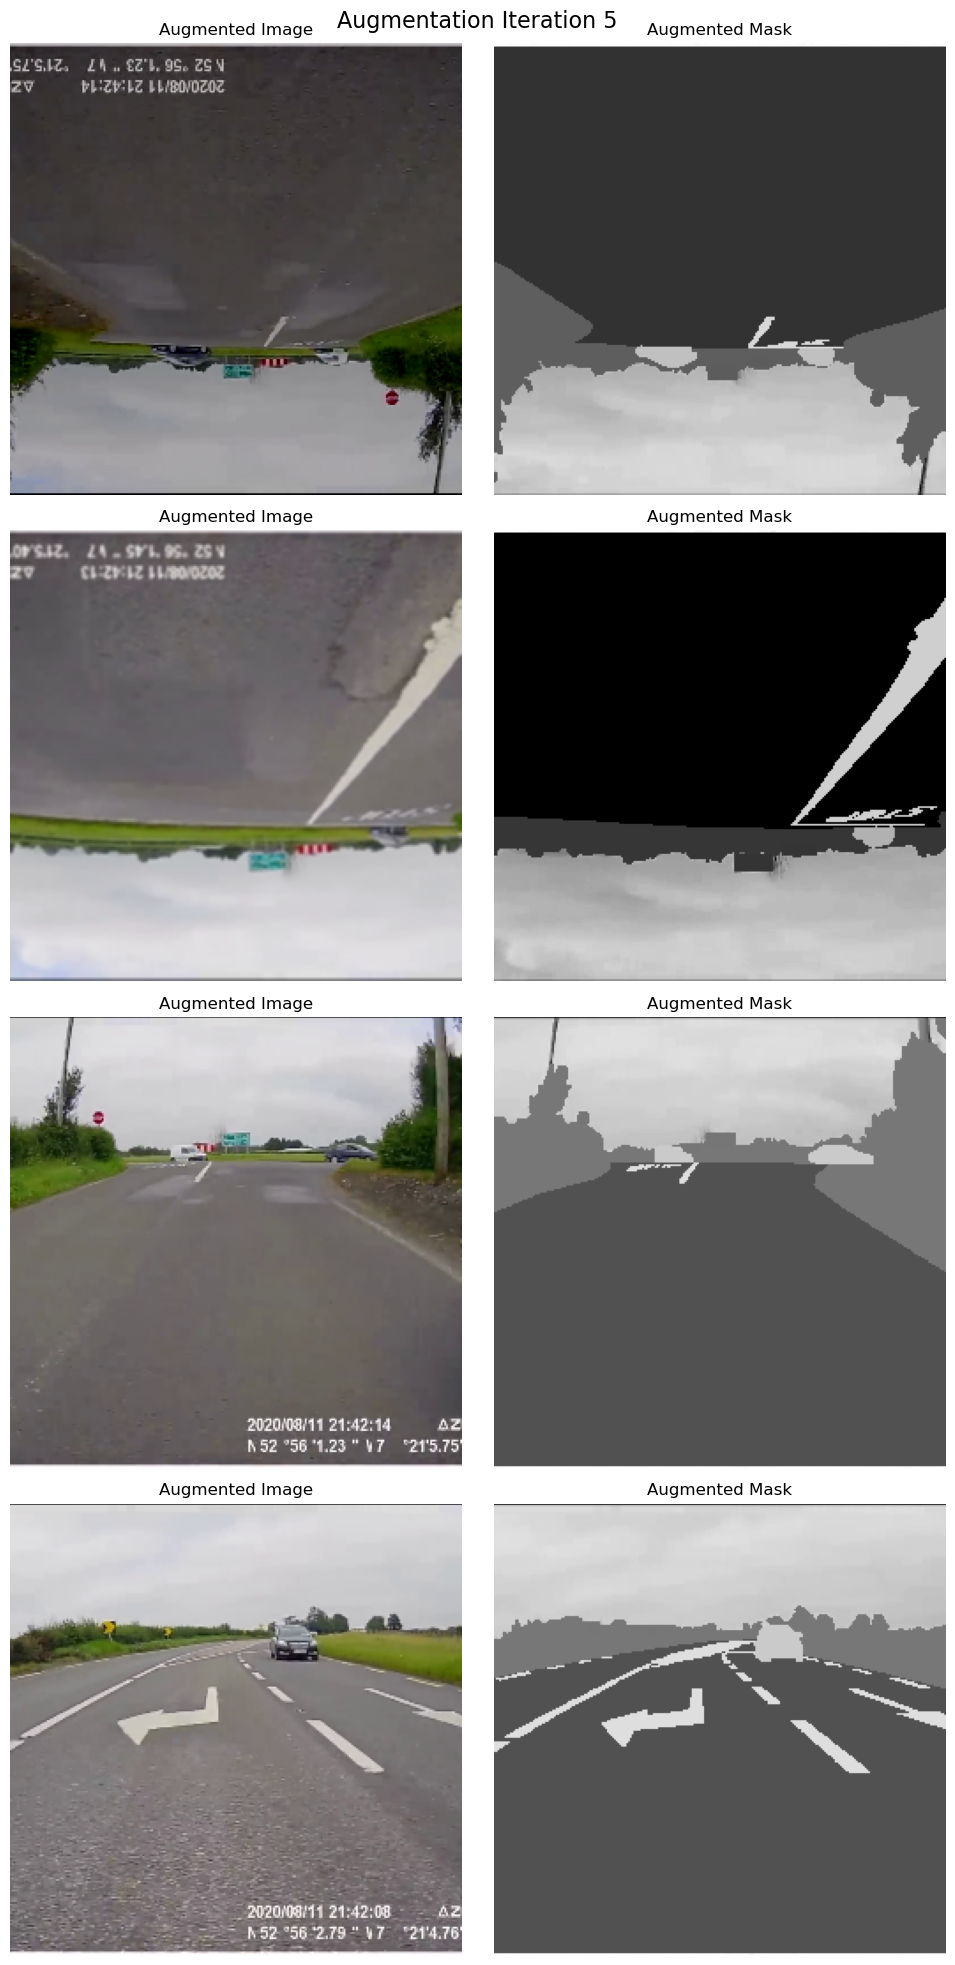

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import random


class RoadSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):

        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_names = sorted(os.listdir(images_dir))
        self.mask_names = sorted(os.listdir(masks_dir))
        assert len(self.image_names) == len(self.mask_names), "Number of images and masks should be equal."

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Get image and mask paths
        img_path = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_names[idx])
        
        # Open images
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))  # Assuming mask is grayscale
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # Convert to tensor if no transform is provided
            image = torch.tensor(image).permute(2, 0, 1).float() / 255.0
            mask = torch.tensor(mask).unsqueeze(0).float() / 255.0  # Assuming binary mask
        
        return image, mask


def get_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(blur_limit=3, p=0.3),
        ToTensorV2()
    ], additional_targets={'mask': 'mask'})

# 3. Visualization Function
def visualize_augmentations(dataset, num_iterations=5, batch_size=4):
    for i in range(num_iterations):
        fig, axes = plt.subplots(4, 2, figsize=(10, 20))
        for j in range(batch_size):
            idx = random.randint(0, len(dataset)-1)
            image, mask = dataset[idx]
            
            # Convert tensors to numpy arrays for plotting
            image_np = image.permute(1, 2, 0).numpy()
            mask_np = mask.squeeze().numpy()
        
            
            # Plot Image
            ax_img = axes[j, 0]
            ax_img.imshow(image_np)
            ax_img.axis('off')
            ax_img.set_title('Augmented Image')
            
            # Plot Mask
            ax_mask = axes[j, 1]
            ax_mask.imshow(mask_np, cmap='gray')
            ax_mask.axis('off')
            ax_mask.set_title('Augmented Mask')
        
        plt.suptitle(f'Augmentation Iteration {i+1}', fontsize=16)
        plt.tight_layout()
        plt.show()



images_dir = 'archive/images'  
masks_dir = 'archive/masks'    


transform = get_transform()
dataset = RoadSegmentationDataset(images_dir=images_dir, masks_dir=masks_dir, transform=transform)


visualize_augmentations(dataset, num_iterations=5, batch_size=4)


Training with Exact Hessian:
Iteration 1/55 | Train Loss: 275.8725 | Test Loss: 105.5633 | Test Acc: 92.98%
Iteration 2/55 | Train Loss: 245.2888 | Test Loss: 95.1493 | Test Acc: 92.98%
Iteration 3/55 | Train Loss: 220.1687 | Test Loss: 86.5513 | Test Acc: 93.57%
Iteration 4/55 | Train Loss: 199.0245 | Test Loss: 79.3110 | Test Acc: 93.57%
Iteration 5/55 | Train Loss: 180.9329 | Test Loss: 73.1149 | Test Acc: 93.57%
Iteration 6/55 | Train Loss: 165.2484 | Test Loss: 67.7420 | Test Acc: 93.57%
Iteration 7/55 | Train Loss: 151.5016 | Test Loss: 63.0388 | Test Acc: 93.57%
Iteration 8/55 | Train Loss: 139.3601 | Test Loss: 58.8860 | Test Acc: 93.57%
Iteration 9/55 | Train Loss: 128.5564 | Test Loss: 55.1961 | Test Acc: 93.57%
Iteration 10/55 | Train Loss: 118.8910 | Test Loss: 51.9005 | Test Acc: 93.57%
Iteration 11/55 | Train Loss: 110.2047 | Test Loss: 48.9451 | Test Acc: 93.57%
Iteration 12/55 | Train Loss: 102.3676 | Test Loss: 46.2832 | Test Acc: 93.57%
Iteration 13/55 | Train Loss: 9

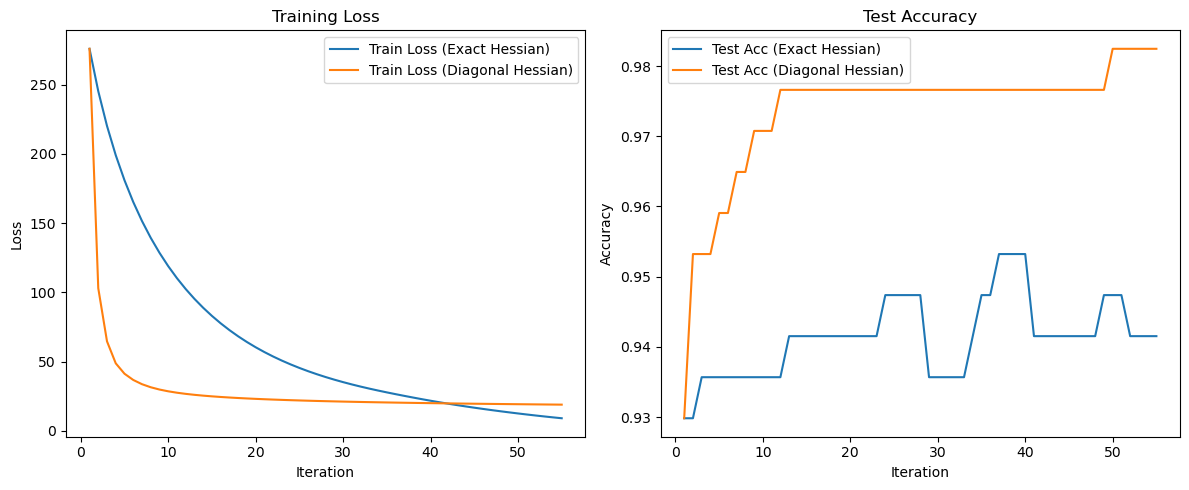

In [15]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



def load_data(test_size=0.3):
    data = load_breast_cancer()
    X = data['data']  
    y = data['target'] 
    
    # Standardize features - # the ed discussion says to standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Add intercept term
    X = np.hstack((np.ones((X.shape[0], 1)), X))  # Shape: (N, D)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape: (N_train, D)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Shape: (N_train, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)    # Shape: (N_test, D)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    # Shape: (N_test, 1)
    
    return X_train, X_test, y_train, y_test


def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

# CL loss
def compute_loss(X, y, w):
    z = X @ w
    loss = -torch.sum(y * torch.log(sigmoid(z) + 1e-15) + (1 - y) * torch.log(1 - sigmoid(z) + 1e-15))
    return loss

def compute_accuracy(X, y, w):
    with torch.no_grad():
        z = X @ w
        preds = sigmoid(z) >= 0.5
        correct = (preds.float() == y).sum().item()
        accuracy = correct / y.shape[0]
    return accuracy

# 3. Implement Newton's Method
def newtons_method(X_train, y_train, X_test, y_test, 
                  max_iters, lr, hessian_type='exact'):
    """
    hessian_type: 'exact' or 'diagonal'
    """
    N, D = X_train.shape
    w = torch.zeros((D, 1), dtype=torch.float32, requires_grad=True)  # Initialize weights
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    for it in range(max_iters):
        # Zero gradients
        if w.grad is not None:
            w.grad.zero_()
        
        # Compute loss
        loss = compute_loss(X_train, y_train, w)
        train_losses.append(loss.item())
        
        # Compute gradient
        loss.backward()
        grad = w.grad.clone()  # Shape: (D, 1)
        
        # Compute Hessian
        with torch.no_grad():
            z = X_train @ w  # Shape: (N, 1)
            probs = sigmoid(z)  # Shape: (N, 1)
            W_diag = probs * (1 - probs)  # Shape: (N, 1)
            W = torch.diagflat(W_diag.squeeze())  # Shape: (N, N)


            H = X_train.t() @ W @ X_train  # Shape: (D, D)
            H= H + 1e-5* torch.eye(H.shape[0]) # add a small value to the diagonal to make it non singular - so dosen't break
            
            if hessian_type == 'diagonal':
                H = torch.diag(torch.diag(H))
            
            H_inv = torch.inverse(H)  # Shape: (D, D)
            
            # Update weights
            w_update = H_inv @ grad  # Shape: (D, 1)
            w = w - lr * w_update
            w = w.detach().requires_grad_(True)
        
        # Compute loss and accuracy on test set
        test_loss = compute_loss(X_test, y_test, w).item()
        test_losses.append(test_loss)
        accuracy = compute_accuracy(X_test, y_test, w)
        test_accuracies.append(accuracy)
        
        # Print progress
        print(f"Iteration {it+1}/{max_iters} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss:.4f} | Test Acc: {accuracy*100:.2f}%")
    
    return train_losses, test_losses, test_accuracies

# 4. Train Models and Plot Results
def train_and_plot():
    X_train, X_test, y_train, y_test = load_data(test_size=0.3)
    
    # Exact Hessian
    print("Training with Exact Hessian:")
    train_losses_exact, test_losses_exact, test_acc_exact = newtons_method(
        X_train, y_train, X_test, y_test, 
        max_iters=55, lr=0.1, hessian_type='exact'
    )
    
    # Diagonal Hessian
    print("\nTraining with Diagonal Hessian:")
    train_losses_diag, test_losses_diag, test_acc_diag = newtons_method(
        X_train, y_train, X_test, y_test, 
        max_iters=55, lr=0.1, hessian_type='diagonal'
    )
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses_exact)+1), train_losses_exact, label='Train Loss (Exact Hessian)')
    plt.plot(range(1, len(train_losses_diag)+1), train_losses_diag, label='Train Loss (Diagonal Hessian)')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(test_acc_exact)+1), test_acc_exact, label='Test Acc (Exact Hessian)')
    plt.plot(range(1, len(test_acc_diag)+1), test_acc_diag, label='Test Acc (Diagonal Hessian)')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Execute the training and plotting
train_and_plot()
